In [1]:
import tensorflow as tf
# from tensorboard.plugins.hparams import api as hp
from tensorflow import keras

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
ratings = pd.read_pickle("./Data/small_random_selection_longform.pkl")
ratings2 = pd.read_pickle("./Data/small_random_selection_longform_2.pkl")

In [4]:
ratings = pd.concat([ratings, ratings2])

In [5]:
ratings.shape

(1111001, 3)

In [7]:
ratings.drop(index=ratings[ratings.duplicated(keep='first')].index, inplace=True)

In [8]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['user_id'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movie_id'].values)
n_movies = ratings['movie'].nunique()

nmovie_id = ratings.movie_id.nunique()
nuser_id = ratings.user_id.nunique()

n_users, n_movies

(44012, 37296)

In [ ]:
# user_enc2 = LabelEncoder()
# ratings2['user'] = user_enc2.fit_transform(ratings2['user_id'].values)
# n_users2 = ratings2['user'].nunique()

# item_enc2 = LabelEncoder()
# ratings2['movie'] = item_enc2.fit_transform(ratings2['movie_id'].values)
# n_movies2 = ratings2['movie'].nunique()

# nmovie_id2 = ratings2.movie_id.nunique()
# nuser_id2 = ratings2.user_id.nunique()

# n_users2, n_movies2

In [9]:
X_train, X_test = train_test_split(ratings[['movie', 'user', 'rating_score']], test_size=0.3, random_state=42)

In [10]:
len(X_train)

650510

In [ ]:
# l2_1 = keras.regularizers.l2(.1)
# l2_01 = 'l2'
# l2_001 = keras.regularizers.l2(.001)

In [22]:
HP_NUM_UNITS = [32,]
HP_DROPOUT = [.3]
HP_LEARNING_RATE = [.1]
HP_EMBEDDING = [5,15,25]

In [20]:
def train_test_model(hparams):
    
    input_movies = keras.layers.Input(shape=[1])
    embed_movies = keras.layers.Embedding(nmovie_id+1, hparams['HP_EMBEDDING'])(input_movies)
    movies_out = keras.layers.Flatten()(embed_movies)

    input_users = keras.layers.Input(shape=[1])
    embed_users = keras.layers.Embedding(nuser_id+1, hparams['HP_EMBEDDING'])(input_users)
    users_out = keras.layers.Flatten()(embed_users)

    conc_layer = keras.layers.Concatenate()([movies_out, users_out])
    x = keras.layers.Dense(hparams['HP_NUM_UNITS'], 
                           activation='relu', 
                           kernel_regularizer='l2')(conc_layer)
    
    dropout = x = keras.layers.Dropout(rate=hparams['HP_DROPOUT'], seed=42)(x)
    
    dense2 = x = keras.layers.Dense(hparams['HP_NUM_UNITS'], 
                           activation='relu', 
                           kernel_regularizer='l2')(conc_layer)
    
    dropout2 = x = keras.layers.Dropout(rate=hparams['HP_DROPOUT'], seed=42)(x)
    
    x_out = x = keras.layers.Dense(1, 
                                   activation='relu',
                                  kernel_regularizer='l2')(x)

    model = keras.Model([input_movies, input_users], x_out)
    
    opt = tf.optimizers.Adam(learning_rate=hparams['HP_LEARNING_RATE'])
    model.compile(optimizer=opt, loss='mean_squared_error', metrics = keras.metrics.RootMeanSquaredError())
    
    hist = model.fit([X_train.movie, X_train.user], 
                 X_train.rating_score,  
                 batch_size=len(X_train), epochs=100, validation_split=.2)

#     print(hist.history['val_mean_squared_error'])
    return hist, model

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        559455      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        660195      input_2[0][0]                    
______________________________________________________________________________________________

In [28]:
model.save('saved_model/copy10/model.h5')

In [23]:
run_history = {}
models = []

session_num = 0

for num_units in HP_NUM_UNITS:
    for dropout_rate in HP_DROPOUT:
        for learning_rate in HP_LEARNING_RATE:
            for embedding in HP_EMBEDDING:
                hparams = {
                'HP_NUM_UNITS': num_units,
                'HP_DROPOUT': dropout_rate,
                'HP_LEARNING_RATE': learning_rate,
                'HP_EMBEDDING': embedding,
                }
                
                run_name = "run-{}".format(session_num)
                print("----Starting trial: {}".format(run_name))
                print(hparams)
                
                output, model = train_test_model(hparams,)
                run_history[run_name] = {
                    'params': hparams,
                    'output': output,
                }
                models.append(model)
                session_num += 1

----Starting trial: run-0
{'HP_NUM_UNITS': 32, 'HP_DROPOUT': 0.3, 'HP_LEARNING_RATE': 0.1, 'HP_EMBEDDING': 5}
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 15.6129 - root_mean_squared_error: 3.9295 - val_loss: 10.1677 - val_root_mean_squared_error: 3.1703
Epoch 2/100
1/1 [==============================] - 1s 588ms/step - loss: 10.1503 - root_mean_squared_error: 3.1675 - val_loss: 3.2476 - val_root_mean_squared_error: 1.7681
Epoch 3/100
1/1 [==============================] - 0s 492ms/step - loss: 3.3750 - root_mean_squared_error: 1.8038 - val_loss: 4.4054 - val_root_mean_squared_error: 2.0582
Epoch 4/100
1/1 [==============================] - 0s 493ms/step - loss: 5.5488 - root_mean_squared_error: 2.3194 - val_loss: 2.2986 - val_root_mean_squared_error: 1.4661
Epoch 5/100
1/1 [==============================] - 1s 547ms/step - loss: 3.0650 - root_mean_squared_error: 1.7076 - val_loss: 1.0284 - val_root_mean_squared_error: 0.9503
Epoch 6/100
1/1 [==================

1/1 [==============================] - 1s 501ms/step - loss: 0.8544 - root_mean_squared_error: 0.9064 - val_loss: 0.8296 - val_root_mean_squared_error: 0.8930
Epoch 49/100
1/1 [==============================] - 0s 440ms/step - loss: 0.8439 - root_mean_squared_error: 0.9010 - val_loss: 0.8218 - val_root_mean_squared_error: 0.8893
Epoch 50/100
1/1 [==============================] - 0s 488ms/step - loss: 0.8314 - root_mean_squared_error: 0.8947 - val_loss: 0.8210 - val_root_mean_squared_error: 0.8896
Epoch 51/100
1/1 [==============================] - 0s 470ms/step - loss: 0.8279 - root_mean_squared_error: 0.8935 - val_loss: 0.8273 - val_root_mean_squared_error: 0.8938
Epoch 52/100
1/1 [==============================] - 0s 464ms/step - loss: 0.8299 - root_mean_squared_error: 0.8952 - val_loss: 0.8330 - val_root_mean_squared_error: 0.8974
Epoch 53/100
1/1 [==============================] - 0s 475ms/step - loss: 0.8321 - root_mean_squared_error: 0.8969 - val_loss: 0.8318 - val_root_mean_squ

Epoch 96/100
1/1 [==============================] - 0s 480ms/step - loss: 0.7435 - root_mean_squared_error: 0.8499 - val_loss: 0.8066 - val_root_mean_squared_error: 0.8863
Epoch 97/100
1/1 [==============================] - 0s 476ms/step - loss: 0.7438 - root_mean_squared_error: 0.8500 - val_loss: 0.8065 - val_root_mean_squared_error: 0.8862
Epoch 98/100
1/1 [==============================] - 1s 548ms/step - loss: 0.7410 - root_mean_squared_error: 0.8484 - val_loss: 0.8065 - val_root_mean_squared_error: 0.8862
Epoch 99/100
1/1 [==============================] - 0s 458ms/step - loss: 0.7411 - root_mean_squared_error: 0.8485 - val_loss: 0.8064 - val_root_mean_squared_error: 0.8861
Epoch 100/100
1/1 [==============================] - 0s 498ms/step - loss: 0.7391 - root_mean_squared_error: 0.8473 - val_loss: 0.8062 - val_root_mean_squared_error: 0.8861
----Starting trial: run-1
{'HP_NUM_UNITS': 32, 'HP_DROPOUT': 0.3, 'HP_LEARNING_RATE': 0.1, 'HP_EMBEDDING': 15}
Epoch 1/100
1/1 [===========

1/1 [==============================] - 1s 525ms/step - loss: 0.8216 - root_mean_squared_error: 0.8938 - val_loss: 0.8089 - val_root_mean_squared_error: 0.8864
Epoch 44/100
1/1 [==============================] - 1s 593ms/step - loss: 0.8077 - root_mean_squared_error: 0.8858 - val_loss: 0.8159 - val_root_mean_squared_error: 0.8901
Epoch 45/100
1/1 [==============================] - 1s 531ms/step - loss: 0.8108 - root_mean_squared_error: 0.8872 - val_loss: 0.8216 - val_root_mean_squared_error: 0.8935
Epoch 46/100
1/1 [==============================] - 1s 565ms/step - loss: 0.8126 - root_mean_squared_error: 0.8884 - val_loss: 0.8153 - val_root_mean_squared_error: 0.8907
Epoch 47/100
1/1 [==============================] - 1s 506ms/step - loss: 0.8022 - root_mean_squared_error: 0.8833 - val_loss: 0.8172 - val_root_mean_squared_error: 0.8926
Epoch 48/100
1/1 [==============================] - 0s 440ms/step - loss: 0.8023 - root_mean_squared_error: 0.8842 - val_loss: 0.8168 - val_root_mean_squ

Epoch 91/100
1/1 [==============================] - 0s 461ms/step - loss: 0.7221 - root_mean_squared_error: 0.8407 - val_loss: 0.7996 - val_root_mean_squared_error: 0.8856
Epoch 92/100
1/1 [==============================] - 1s 511ms/step - loss: 0.7217 - root_mean_squared_error: 0.8404 - val_loss: 0.7995 - val_root_mean_squared_error: 0.8856
Epoch 93/100
1/1 [==============================] - 0s 451ms/step - loss: 0.7205 - root_mean_squared_error: 0.8398 - val_loss: 0.7992 - val_root_mean_squared_error: 0.8855
Epoch 94/100
1/1 [==============================] - 0s 476ms/step - loss: 0.7174 - root_mean_squared_error: 0.8381 - val_loss: 0.7989 - val_root_mean_squared_error: 0.8854
Epoch 95/100
1/1 [==============================] - 1s 526ms/step - loss: 0.7172 - root_mean_squared_error: 0.8380 - val_loss: 0.7988 - val_root_mean_squared_error: 0.8854
Epoch 96/100
1/1 [==============================] - 1s 508ms/step - loss: 0.7140 - root_mean_squared_error: 0.8361 - val_loss: 0.7986 - val_

1/1 [==============================] - 1s 529ms/step - loss: 1.6027 - root_mean_squared_error: 1.0514 - val_loss: 1.4111 - val_root_mean_squared_error: 0.9618
Epoch 39/100
1/1 [==============================] - 1s 629ms/step - loss: 1.4045 - root_mean_squared_error: 0.9583 - val_loss: 1.3424 - val_root_mean_squared_error: 0.9304
Epoch 40/100
1/1 [==============================] - 1s 575ms/step - loss: 1.3742 - root_mean_squared_error: 0.9474 - val_loss: 1.4217 - val_root_mean_squared_error: 0.9778
Epoch 41/100
1/1 [==============================] - 1s 547ms/step - loss: 1.4826 - root_mean_squared_error: 1.0085 - val_loss: 1.4006 - val_root_mean_squared_error: 0.9750
Epoch 42/100
1/1 [==============================] - 1s 561ms/step - loss: 1.4582 - root_mean_squared_error: 1.0041 - val_loss: 1.3000 - val_root_mean_squared_error: 0.9324
Epoch 43/100
1/1 [==============================] - 1s 552ms/step - loss: 1.3218 - root_mean_squared_error: 0.9440 - val_loss: 1.3094 - val_root_mean_squ

Epoch 86/100
1/1 [==============================] - 1s 514ms/step - loss: 0.9085 - root_mean_squared_error: 0.8944 - val_loss: 0.9489 - val_root_mean_squared_error: 0.9185
Epoch 87/100
1/1 [==============================] - 1s 523ms/step - loss: 0.9041 - root_mean_squared_error: 0.8937 - val_loss: 0.9436 - val_root_mean_squared_error: 0.9169
Epoch 88/100
1/1 [==============================] - 1s 543ms/step - loss: 0.8987 - root_mean_squared_error: 0.8921 - val_loss: 0.9374 - val_root_mean_squared_error: 0.9146
Epoch 89/100
1/1 [==============================] - 0s 497ms/step - loss: 0.8940 - root_mean_squared_error: 0.8905 - val_loss: 0.9330 - val_root_mean_squared_error: 0.9132
Epoch 90/100
1/1 [==============================] - 1s 523ms/step - loss: 0.8935 - root_mean_squared_error: 0.8914 - val_loss: 0.9300 - val_root_mean_squared_error: 0.9129
Epoch 91/100
1/1 [==============================] - 1s 515ms/step - loss: 0.8909 - root_mean_squared_error: 0.8912 - val_loss: 0.9280 - val_

In [24]:
import matplotlib.pyplot as plt

In [25]:
len(run_history.keys())

3

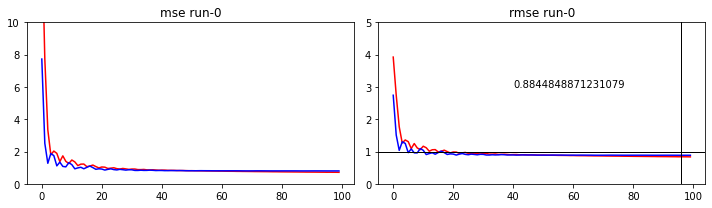

In [18]:
fig, axs = plt.subplots(ncols=2, nrows=len(run_history.keys()), figsize=(10, len(run_history.keys())*3))

for n, key in enumerate(run_history.keys()):
    axs[0].plot(run_history[key]['output'].history['loss'], color='r')
    axs[0].plot(run_history[key]['output'].history['val_loss'], color='b')
    
    axs[1].plot(run_history[key]['output'].history['root_mean_squared_error'], color='r')
    axs[1].plot(run_history[key]['output'].history['val_root_mean_squared_error'], color='b')
    axs[1].axvline(np.where(run_history[key]['output'].history['val_root_mean_squared_error']==np.min(run_history[key]['output'].history['val_root_mean_squared_error'])), 
                     color='k', lw=1)
    axs[1].annotate(str(np.min(run_history[key]['output'].history['val_root_mean_squared_error'])),
                        xy=(40,3),)
    
#     title_str = '-'.join(str(run_history[key]['params'][param]) for param in run_history[key]['params'].keys(),
#                         xytext=(.8,.8), xycoords='subfigure fraction')
    
    axs[0].set_title("mse {}".format(key))
    axs[1].set_title("rmse {}".format(key))
    
    axs[0].set_ylim(0,10)
    axs[1].set_ylim(0,5)
    
    axs[1].axhline(1, color='k', lw=1)
    
plt.tight_layout()   
plt.show()

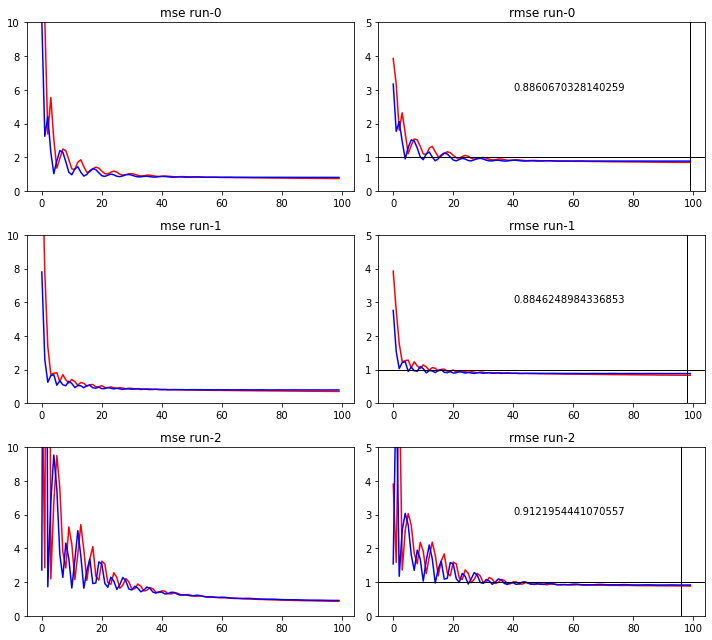

In [26]:
fig, axs = plt.subplots(ncols=2, nrows=len(run_history.keys()), figsize=(10, len(run_history.keys())*3))

for n, key in enumerate(run_history.keys()):
    axs[n,0].plot(run_history[key]['output'].history['loss'], color='r')
    axs[n,0].plot(run_history[key]['output'].history['val_loss'], color='b')
    
    axs[n,1].plot(run_history[key]['output'].history['root_mean_squared_error'], color='r')
    axs[n,1].plot(run_history[key]['output'].history['val_root_mean_squared_error'], color='b')
    axs[n,1].axvline(np.where(run_history[key]['output'].history['val_root_mean_squared_error']==np.min(run_history[key]['output'].history['val_root_mean_squared_error'])), 
                     color='k', lw=1)
    axs[n,1].annotate(str(np.min(run_history[key]['output'].history['val_root_mean_squared_error'])),
                        xy=(40,3),)
    
#     title_str = '-'.join(str(run_history[key]['params'][param]) for param in run_history[key]['params'].keys(),
#                         xytext=(.8,.8), xycoords='subfigure fraction')
    
    axs[n,0].set_title("mse {}".format(key))
    axs[n,1].set_title("rmse {}".format(key))
    
    axs[n,0].set_ylim(0,10)
    axs[n,1].set_ylim(0,5)
    
    axs[n, 1].axhline(1, color='k', lw=1)
    
plt.tight_layout()   
plt.show()

In [27]:
# print(run_history['run-0'])
print(run_history['run-1'])
# print(run_history['run-2'])
print(run_history['run-3'])
print(run_history['run-6'])

{'params': {'HP_NUM_UNITS': 32, 'HP_DROPOUT': 0.3, 'HP_LEARNING_RATE': 0.1, 'HP_EMBEDDING': 15}, 'output': <tensorflow.python.keras.callbacks.History object at 0x7f06b45474f0>}


KeyError: 'run-3'

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

colors = ['red', 'blue', 'green']
for n, key in enumerate(['run-0', 'run-3', 'run-6']):
    
    ax.plot(run_history[key]['output'].history['val_root_mean_squared_error'], color=colors[n], alpha=.8, lw=2)

ax.set_ylim(0,5)
plt.show()

In [29]:
ratings.groupby('user_id').count().sort_values(by='movie_id',ascending=False).head()

,movie_id,rating_score,user,movie
user_id,,,,
44117354,111,111,111,111
70183010,106,106,106,106
25219708,103,103,103,103
30484208,102,102,102,102
69239795,101,101,101,101


In [30]:
user_id = 44117354
ratings[ratings.user_id==user_id]

,movie_id,rating_score,user_id,user,movie
3675,830,4,44117354,19690,759
9918,31747,3,44117354,19690,13001
16199,133823,2,44117354,19690,30304
44079,26024,2,44117354,19690,9692
59731,93537,5,44117354,19690,23232
...,...,...,...,...,...
578048,45023,5,44117354,19690,18491
622495,27447,4,44117354,19690,10569
634079,147,3,44117354,19690,111
668979,197,1,44117354,19690,160


In [31]:
user = 19690

In [32]:
movie_array = ratings[ratings.user_id==user_id].movie.values.astype(int)
user = np.array([int(user) for n in range(len(movie_array))])

In [37]:
pred = model.predict([movie_array, user])

In [38]:
list(zip(zip(pred.flatten(), ratings[ratings.user_id==user_id].rating_score.values),movie_array))

[((4.443749, 4), 759),
 ((3.0487213, 3), 13001),
 ((3.4955826, 2), 30304),
 ((4.2365317, 2), 9692),
 ((4.620772, 5), 23232),
 ((4.2911863, 5), 113),
 ((4.0627294, 5), 108),
 ((3.4778192, 3), 4704),
 ((3.7692504, 5), 2531),
 ((3.6930926, 4), 26290),
 ((3.4296114, 2), 1485),
 ((4.2770286, 4), 2103),
 ((3.4494987, 3), 10623),
 ((3.7676442, 5), 11182),
 ((4.4641213, 5), 903),
 ((3.811058, 5), 32392),
 ((3.9964552, 4), 17994),
 ((4.216799, 5), 32233),
 ((3.507463, 3), 3041),
 ((3.8077025, 3), 27185),
 ((2.762479, 4), 27443),
 ((4.434957, 5), 25895),
 ((4.169401, 2), 8461),
 ((3.0923502, 2), 3107),
 ((3.6240742, 4), 4452),
 ((4.223429, 5), 273),
 ((3.3390841, 3), 9604),
 ((4.2326694, 5), 22203),
 ((3.0539048, 3), 35191),
 ((4.018703, 5), 11221),
 ((3.3099916, 2), 1647),
 ((3.6017835, 5), 2883),
 ((3.4528334, 3), 3043),
 ((3.611532, 4), 5636),
 ((3.4521797, 4), 30965),
 ((3.3492951, 3), 1683),
 ((4.351111, 5), 9463),
 ((3.7766812, 3), 152),
 ((4.351217, 5), 814),
 ((3.9190128, 5), 12551),
 ((

In [52]:
def is_close_enough(pred, ratings):
    val = []
    for pair in zip(pred, ratings):
        val.append(pair[1] - .5 <= pair[0] <= pair[1] + .5)
        
    return val

In [53]:
val = is_close_enough(np.round(pred.flatten(), 1), ratings[ratings.user_id==user_id].rating_score.values)

In [55]:
sum(val) / len(pred.flatten())

0.3963963963963964

In [47]:
np.round(pred.flatten(), 1)[0] - .5 <= 2 <= np.round(pred.flatten(), 1)[0] + .5

False

In [41]:
ratings[ratings.user_id==user_id].rating_score.values[0]

4

In [54]:
list(zip(zip(np.round(pred.flatten(), 1), ratings[ratings.user_id==user_id].rating_score.values),val))

[((4.4, 4), True),
 ((3.0, 3), True),
 ((3.5, 2), False),
 ((4.2, 2), False),
 ((4.6, 5), True),
 ((4.3, 5), False),
 ((4.1, 5), False),
 ((3.5, 3), True),
 ((3.8, 5), False),
 ((3.7, 4), True),
 ((3.4, 2), False),
 ((4.3, 4), True),
 ((3.4, 3), True),
 ((3.8, 5), False),
 ((4.5, 5), True),
 ((3.8, 5), False),
 ((4.0, 4), True),
 ((4.2, 5), False),
 ((3.5, 3), True),
 ((3.8, 3), False),
 ((2.8, 4), False),
 ((4.4, 5), False),
 ((4.2, 2), False),
 ((3.1, 2), False),
 ((3.6, 4), True),
 ((4.2, 5), False),
 ((3.3, 3), True),
 ((4.2, 5), False),
 ((3.1, 3), True),
 ((4.0, 5), False),
 ((3.3, 2), False),
 ((3.6, 5), False),
 ((3.5, 3), True),
 ((3.6, 4), True),
 ((3.5, 4), True),
 ((3.3, 3), True),
 ((4.4, 5), False),
 ((3.8, 3), False),
 ((4.4, 5), False),
 ((3.9, 5), False),
 ((4.5, 5), True),
 ((3.6, 5), False),
 ((3.8, 5), False),
 ((3.9, 5), False),
 ((4.4, 4), True),
 ((3.1, 4), False),
 ((3.0, 1), False),
 ((3.8, 4), True),
 ((3.4, 3), True),
 ((3.9, 5), False),
 ((4.0, 5), False),
 